In [2660]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6.4*4,4.8*2)
plt.rcParams["font.size"] = 20

import numpy as np
from scipy import special
import util

31.830988618379067
(20.0, 100.0)
9.396493890795204
3.0653701066584444


(0.0, 200.0)

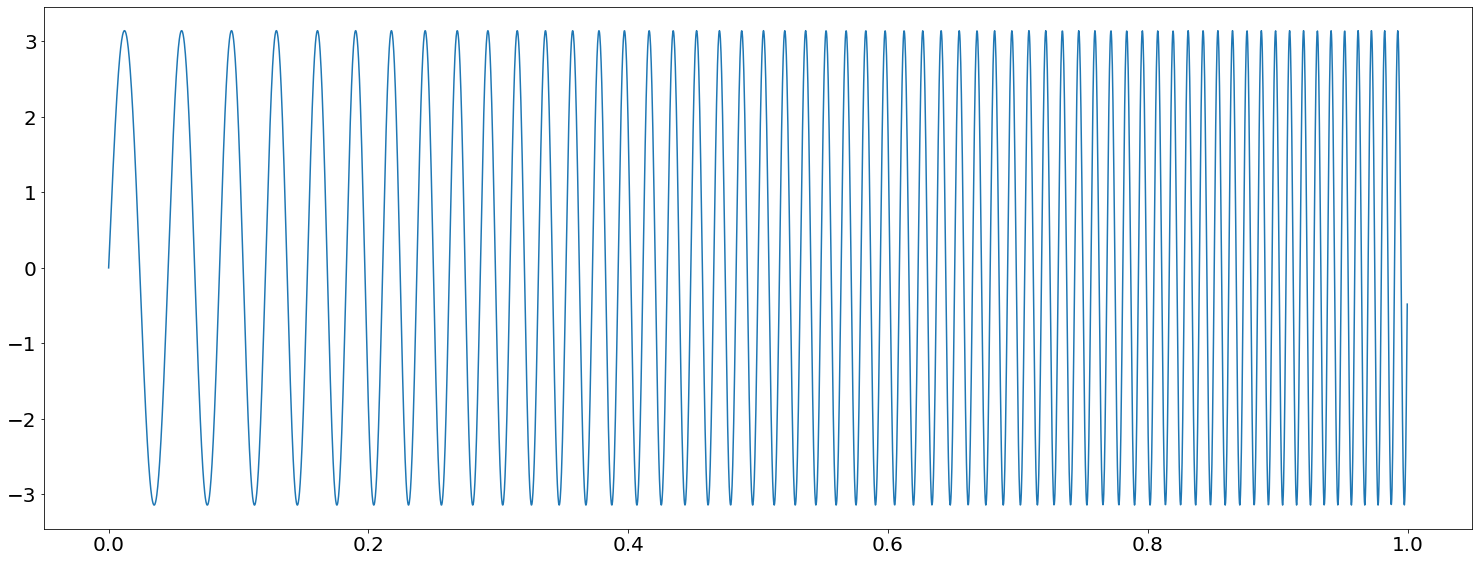

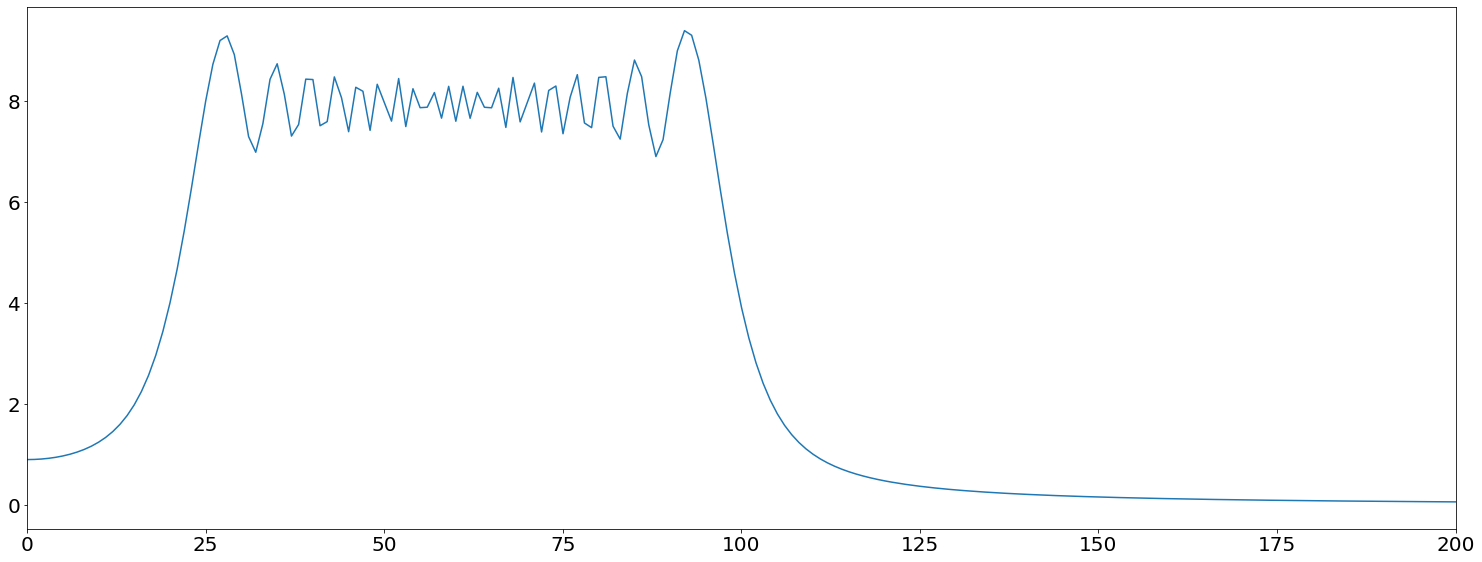

In [2661]:
def swept_sine(f1: float, f2: float, Ts: float=1) -> None:
    ''' f1, f2, in Hertz
        TS in seconds
    '''

    # f0 is the minimum resolution
    f0 = 1 / Ts
    #assert f1 < fc and f2 < fc
    k1 = int(np.round(f1 / f0))
    k2 = int(np.round(f2 / f0))

    # k1 and k2 must be positive ints and > 1, otherwise the frequency resolution is not enough within the given time window
    # k2 > k1
    assert k1 > 1 and k2 > 1
    assert k2 > k1

    a = np.pi * (k2 - k1) * f0**2
    b = 2 * np.pi * k1 * f0

    # TODO: how many points are required to avoid freq domain aliasing?
    print(k2 * f0 / np.pi)
    # np.pi / N 
    N = 4096
    n = np.linspace(0, Ts, N, endpoint=False)

    f1 = k1 * f0
    f2 = k2 * f0
    return n, np.sin((a * n + b) * n), (f1, f2)


t, sig, freqs = swept_sine(20, 100, Ts=1)
sig = sig * np.pi
print(freqs)

smoother = 1
ffted = np.fft.rfft(sig, len(sig) * smoother, norm='ortho') / np.sqrt(2)
print(np.amax(np.abs(ffted)))
print(np.sqrt(np.amax(np.abs(ffted))))
plt.plot(t, sig)
plt.figure()
plt.plot(np.linspace(0, len(ffted) / smoother, len(ffted)), np.abs(ffted))
plt.xlim(0, 200)


In [2662]:
def shroeder_band_multisine(f1, f2, Ts, F) -> None:
	# F is the number of distinct spectral lines
	f0 = 1 / Ts
	k1 = int(np.round(f1 / f0))
	k2 = int(np.floor(f2 / f0))

	fs = (k2 - k1) * f0 / F
	print(fs)

	k = np.arange(k1, k2, fs)

	print(k1, k2)
	print(len(k))
	phases = -k * (k - 1)
	freqs =  k * fs
	Fs = int(round(k2 / fs))

	prezp = np.zeros(int(round(k1 / fs)))
	postzp = np.zeros(int(round(k2 / fs)))
	#positive_spectrum = list(prezp) + list(np.exp(1j * np.pi / Fs * (freqs + phases))) + list(postzp)
	positive_spectrum = list(prezp) + list(np.exp(1j * np.pi / Fs * (freqs + phases)))
	negative_spectrum = np.conj(np.flip(positive_spectrum))
	# create oscillator bank with dc value U[0] = 0
	U = np.array([0] + list(positive_spectrum) + list(negative_spectrum), dtype=np.complex128)

	# extract the continuous time domain signal corresponding to the constructed fourier series (hermitian spectrum)
	# norm of "ortho" applies a 1/sqrt(N) scaling, as desired
	u = np.fft.ifft(U, norm="ortho")
	return u, U


1.00354609929078
20 303
282


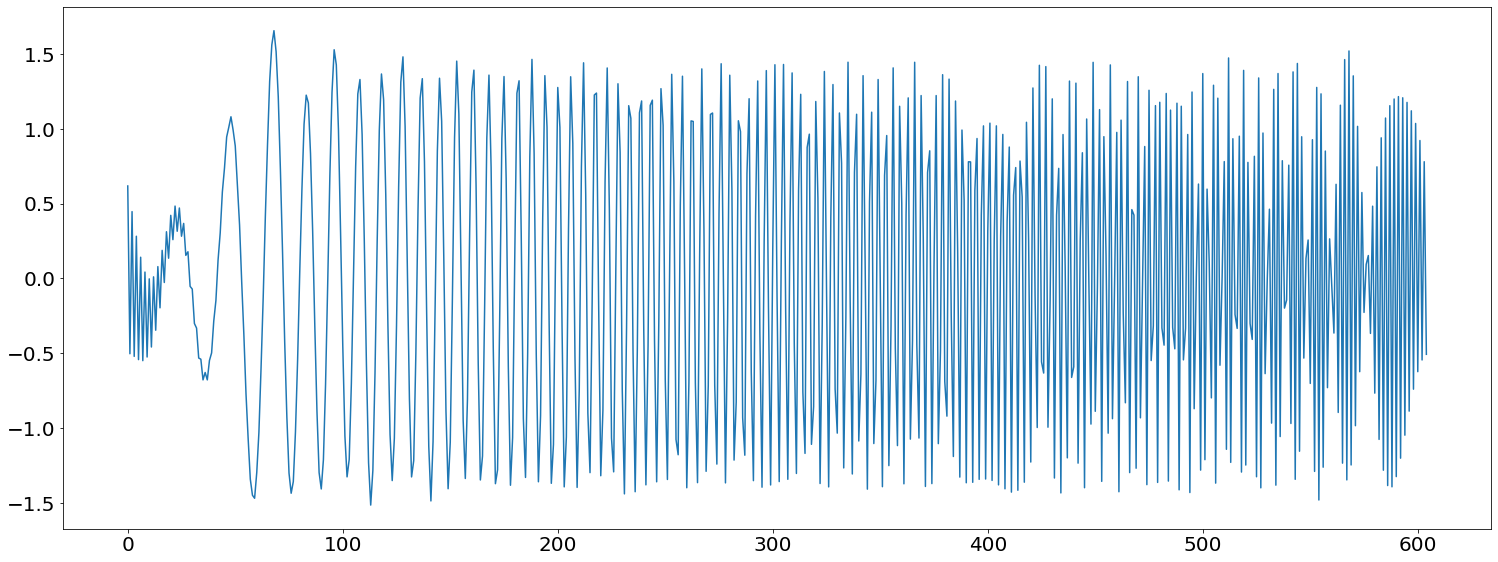

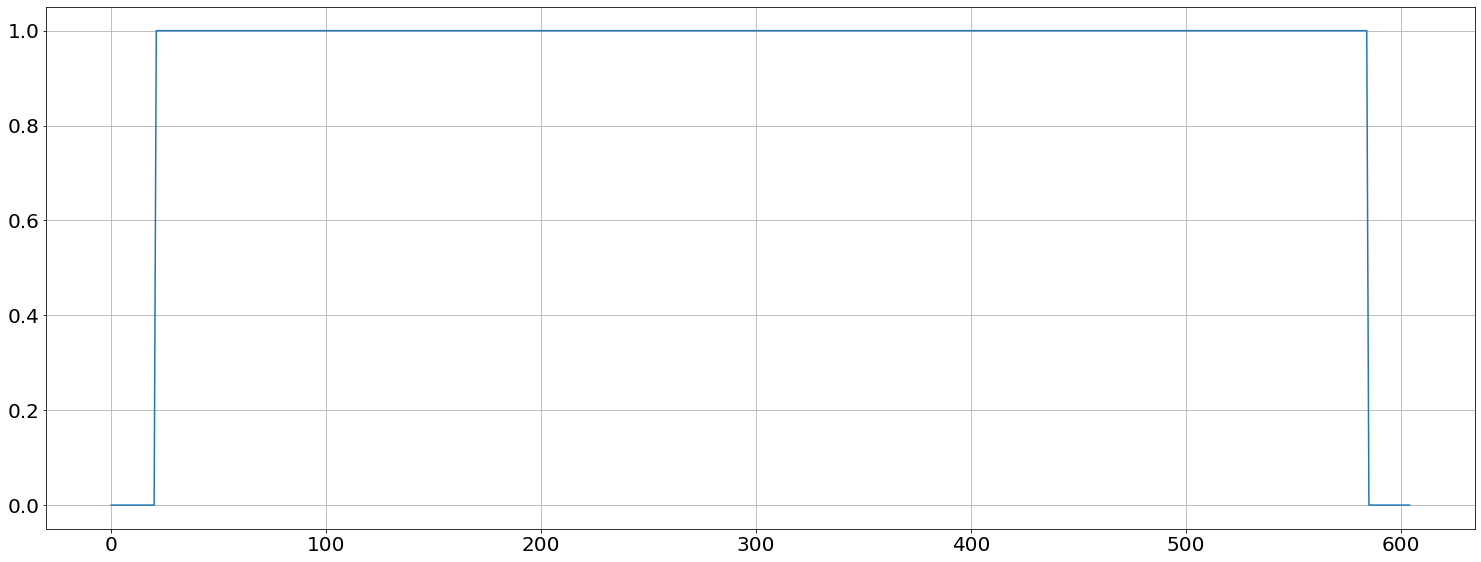

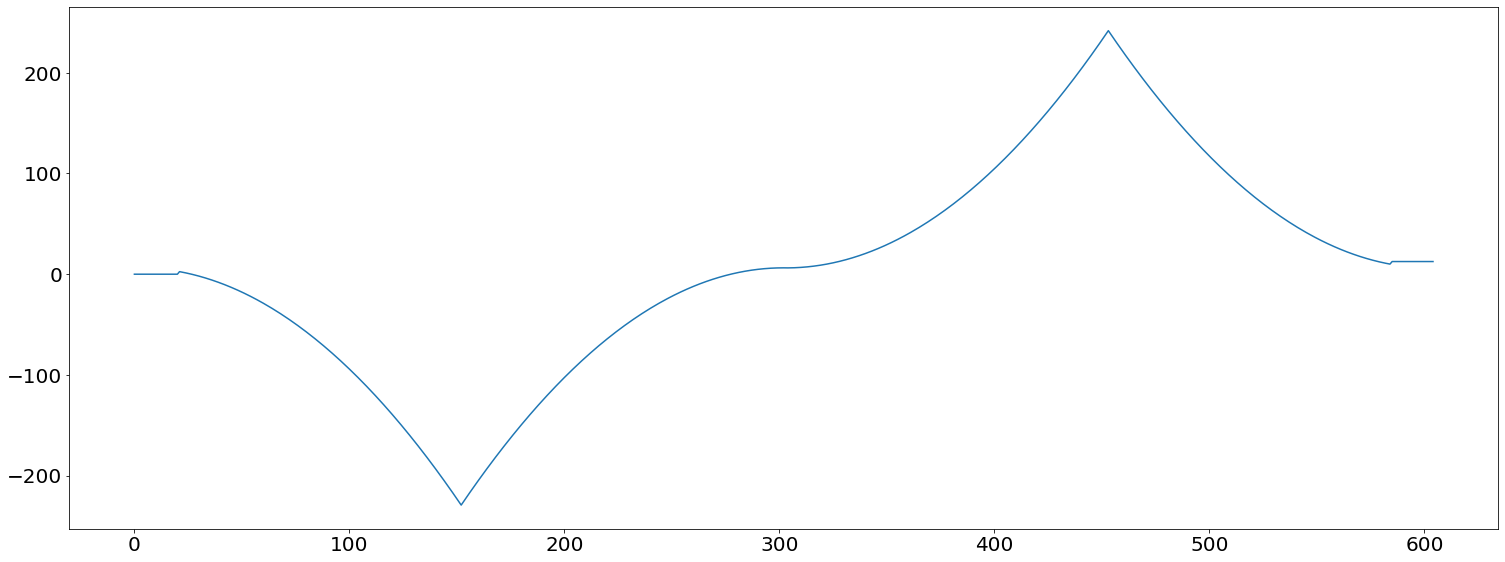

In [2663]:
u, U = shroeder_band_multisine(20, 303, 1, 303-20-1)

#U = np.fftshift
u = np.real(u)
plt.plot(u)
plt.figure()
plt.plot(np.abs(U[:len(U)]))
#plt.xlim(0, 350)
plt.grid()
plt.figure()
plt.plot(util.unwrap_spectral_phase(np.angle(U)))

In [3153]:
def plot_excitation_signal(u, U, title='0'):
	fig, axs = plt.subplots(2,2)
	fig.suptitle(title)
	fig.set_tight_layout(True)
	axts = axs[0, 0]
	axtcycles = axs[1, 0]
	axmag = axs[0, 1]
	axphase = axs[1, 1]

	axts.set_title('Time Series Signal')
	sig = np.fft.ifftshift(u)
	axts.plot(np.real(sig), marker='o')
	axts.plot(np.imag(sig), marker='o', alpha=0.3)
	#axts.plot(np.abs(u), marker='o', alpha=0.3)

	#checkfft = np.fft.fft(sig, norm="ortho")
#	axmag.plot(np.abs(checkfft), marker='o')
	axmag.set_title('Amplitude Response (Gain)')
	axmag.plot(np.abs(U), marker='o')

	phase = np.angle(U)
	axphase.plot(util.unwrap_spectral_phase(phase), marker='o')
	#axphase.plot(phase, marker='o')
	axphase.axvline(x=len(phase) // 2)
	axphase.set_title('Phase (rad/s)')

	#axtcycles.plot(np.concatenate((np.real(sig), np.real(sig))))
	axtcycles.plot(np.imag(sig))


In [3154]:
def periodic_noise(N, timelimited=False, process=None):
    if process is None:
        process = np.random.default_rng()

    odd = 0 if N % 2 else 1
    N2 = (N-odd) // 2
    k = process.integers(low=1, high=N, size=N2)

    pspec = k / N * np.exp(1j * 2 * np.pi * -k / N)
    nspec = np.conj(np.flip(pspec))
    if timelimited:
        spectrum = np.concatenate((pspec, np.zeros(1), nspec))
    else:
        spectrum = np.concatenate((np.zeros(1), pspec, nspec))

    u = np.fft.ifft(spectrum, norm="ortho")
    return u, spectrum


In [3161]:
def random_phase_multisine(N, timelimited=False, process=None):
    if process is None:
        process = np.random.default_rng()

    spectrum = None

    odd = 0 if N % 2 else 1
    N2 = (N-odd) // 2
    k = process.integers(low=1, high=N, size=N2)

    pspec = np.exp(1j * 2 * np.pi * -k / N)
    nspec = np.conj(np.flip(pspec))
    if timelimited:
        spectrum = np.concatenate((pspec, np.zeros(1), nspec))
    else:
        spectrum = np.concatenate((np.zeros(1), pspec, nspec))

    u = np.fft.ifft(spectrum, norm="ortho")
    return u, spectrum

In [3162]:
def chirp(N, timelimited=False, transform='linear', process=None):
    spectrum = None

    odd = 0 if N % 2 else 1
    N2 = (N-odd) // 2
    phase = np.linspace(1, N2, N2)

    #phase = np.arange(1, N2-1)
    if transform == 'linear':
        #phase = np.arange(1, N2, 2)
        k = -phase*(phase - 1)
    else:
        phase = np.arange(1, N2, 1)
        k = phase / 2

    pspec = np.exp(1j * 2 * np.pi * k / N)
    nspec = np.conj(np.flip(pspec))
    if timelimited:
        spectrum = np.concatenate((pspec,np.zeros(1), nspec))
    else:
        spectrum = np.concatenate(([1],pspec, nspec))
        #spectrum = np.concatenate((pspec, np.zeros(2), nspec))
    #else:
        #spectrum = np.concatenate((np.zeros(2), pspec, nspec))

    u = np.fft.ifft(spectrum, norm="ortho")
    return u, spectrum

In [3163]:
def chirp2(N, timelimited=False, transform='linear', process=None):
    spectrum = None

    odd = 0 if N % 2 else 1
    N2 = (N-odd) // 2
    #phase = np.linspace(1, N, N2-2)
    
    phase = np.arange(1, N2, 2)
    #phase = np.linspace(1, N2/2, N2)
    print(phase)
    if transform == 'linear':
        k = -phase*(phase - 1)
    else:
        k = phase

    pspec = np.exp(1j * 2 * np.pi / N * k)
    nspec = np.conj(np.flip(pspec))
    if timelimited:
        spectrum = np.concatenate((nspec, np.zeros(2), pspec))
    else:
        spectrum = np.concatenate((np.zeros(2), pspec, nspec, np.zeros(pspec.size*4+2)))

    u = np.fft.ifft(spectrum, norm="ortho")
    return u, spectrum

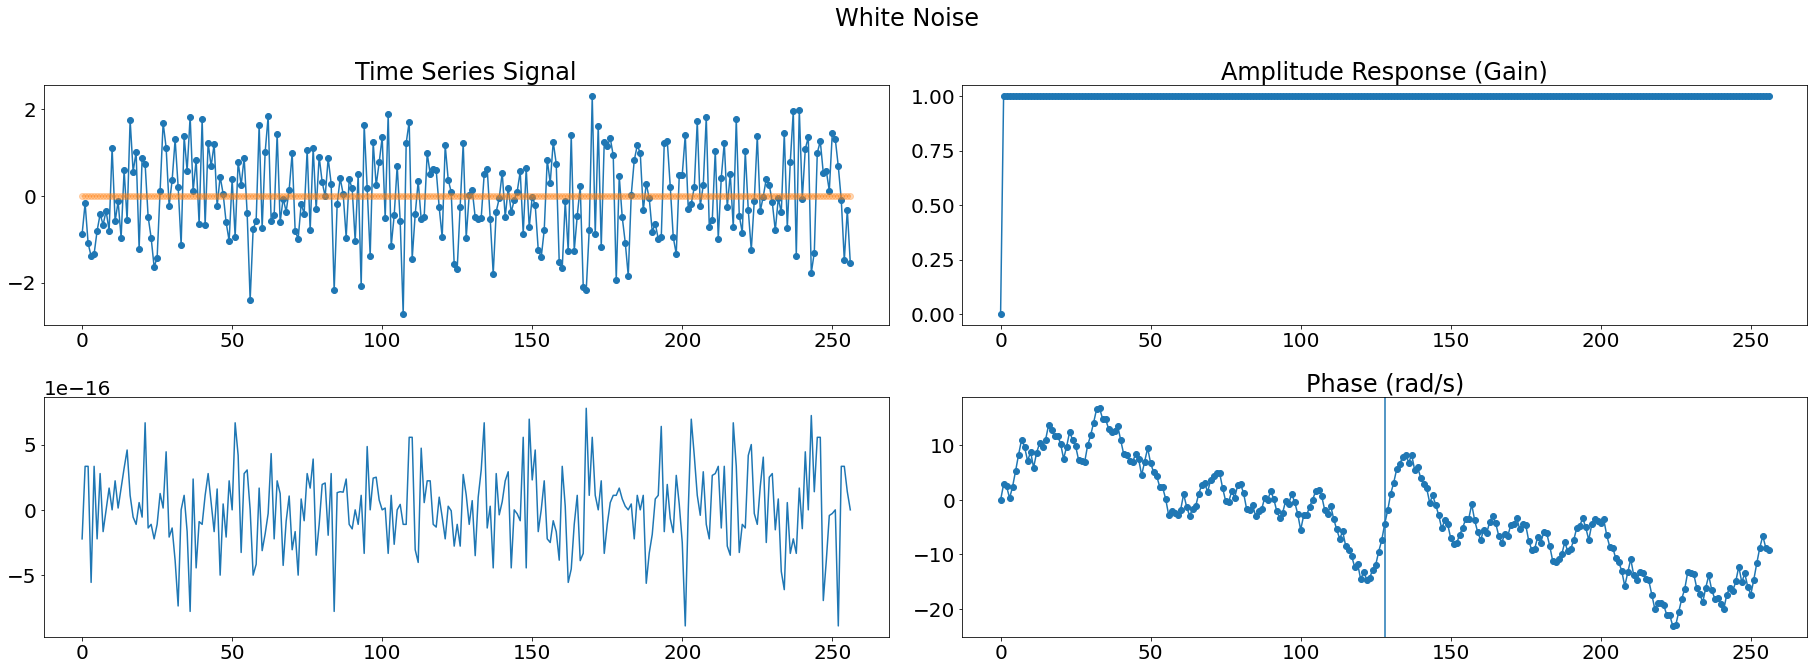

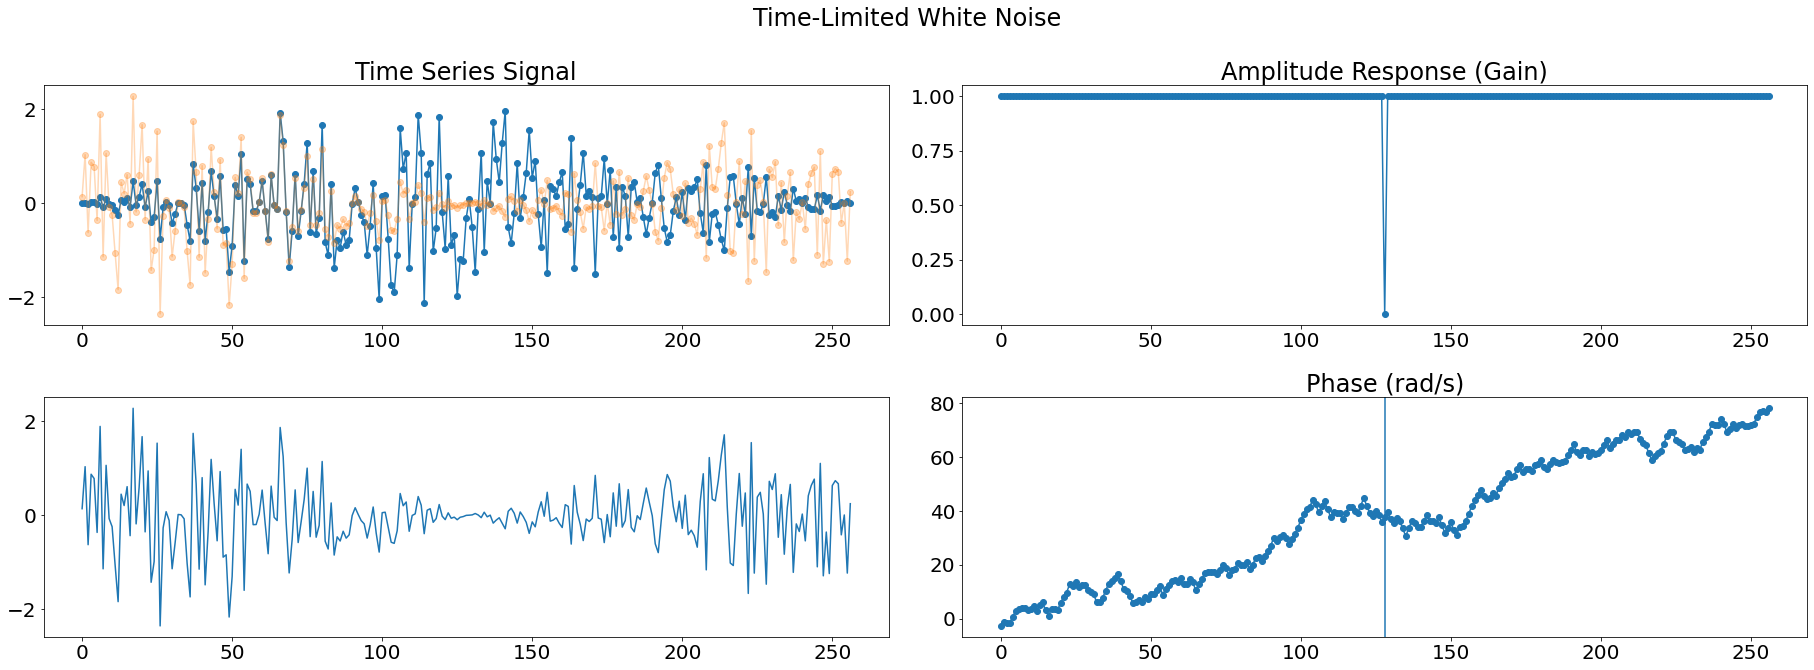

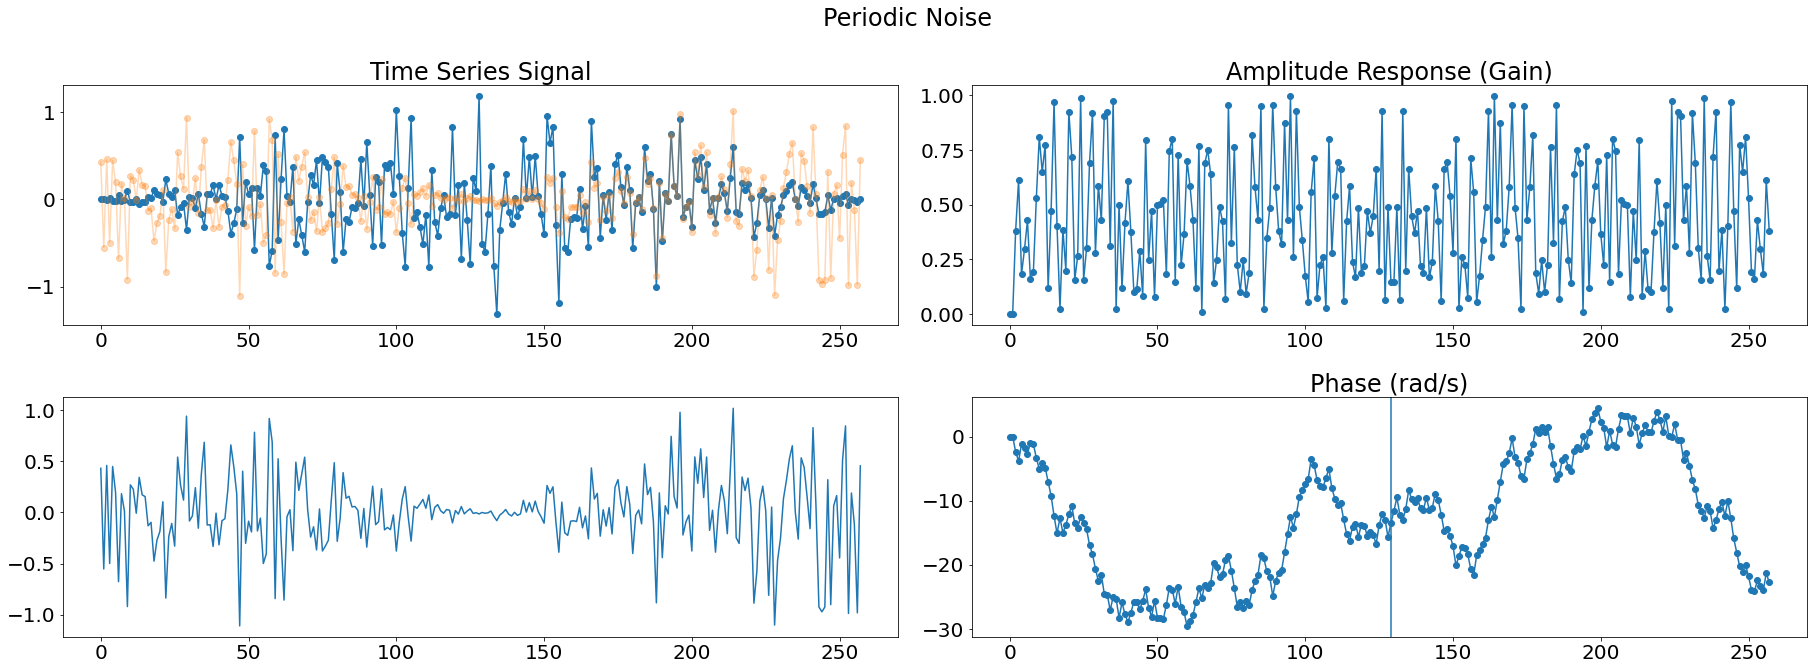

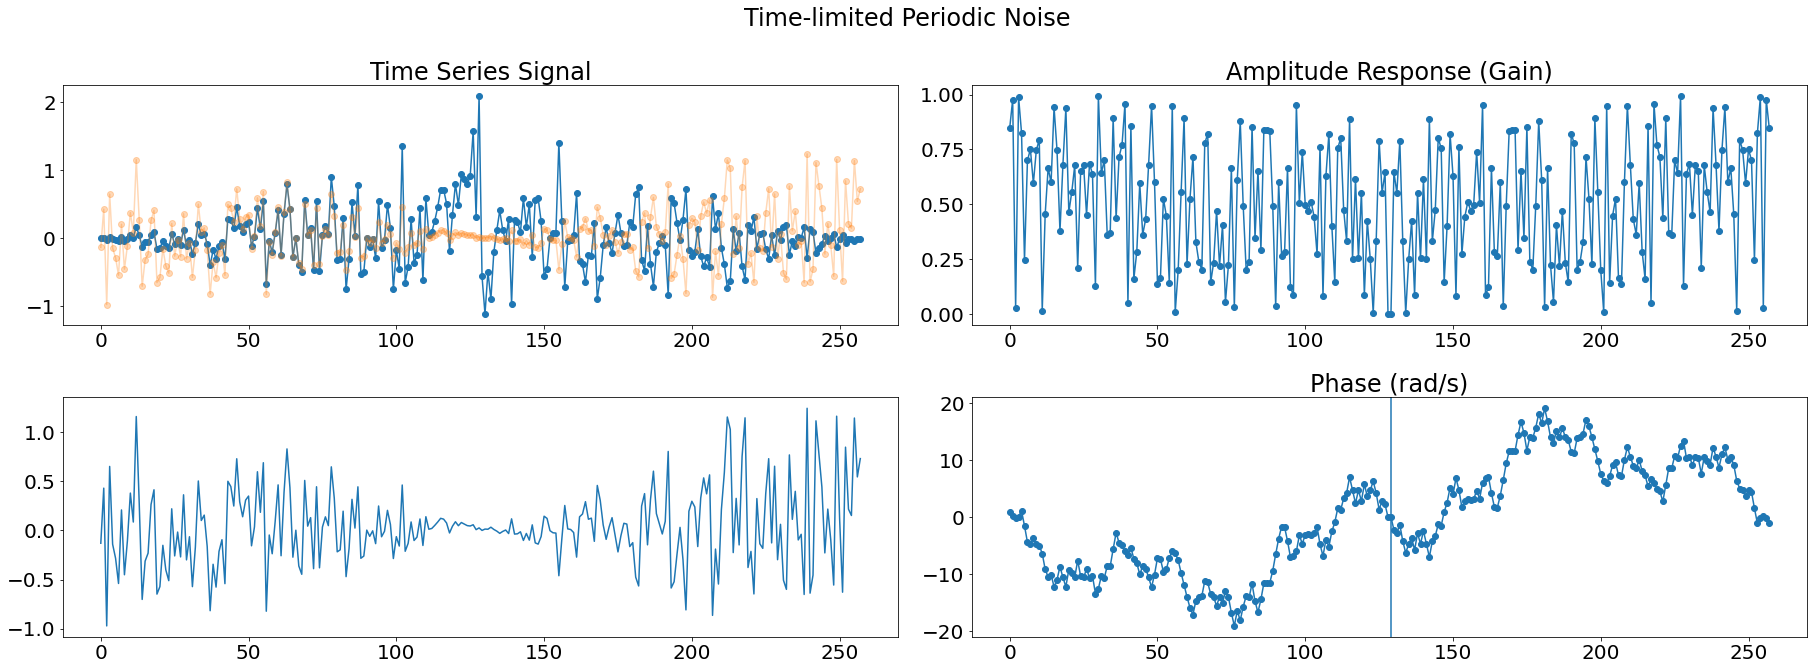

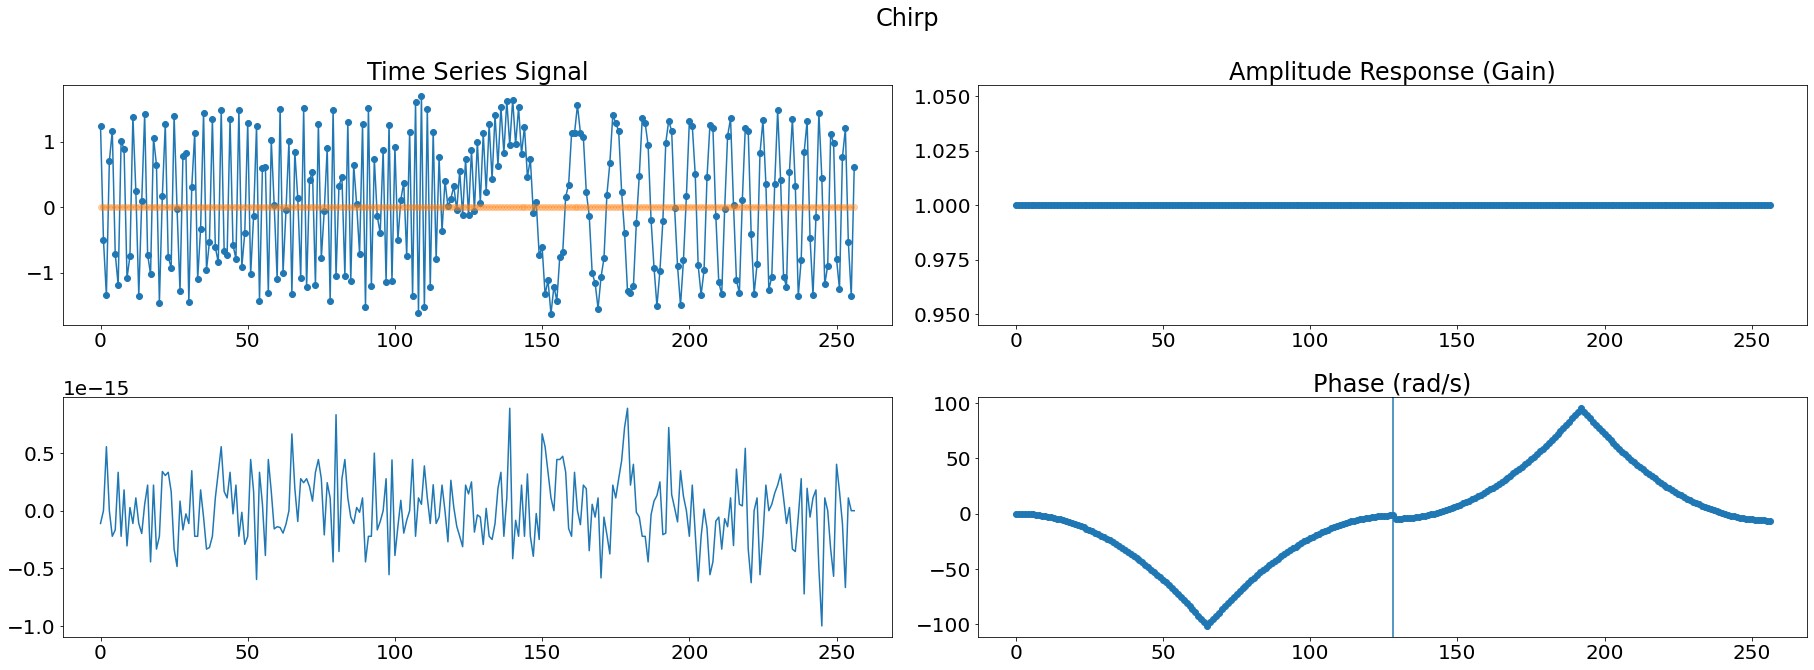

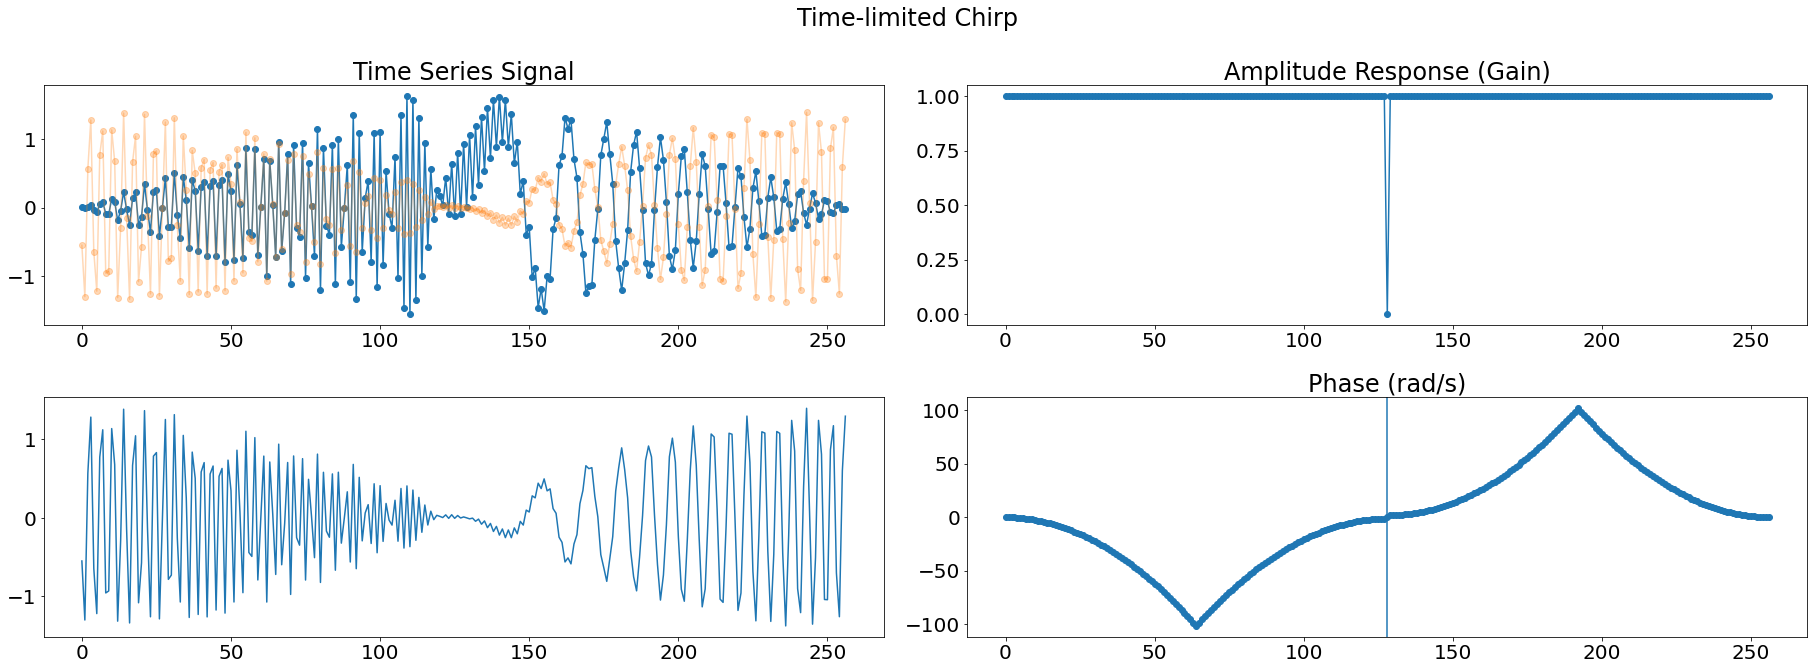

In [3167]:
N = 257
u, U = random_phase_multisine(N)
u1, U1 = random_phase_multisine(N, timelimited=True)
# periodic noise
u2, U2 = periodic_noise(N)
u3, U3 = periodic_noise(N, timelimited=True)

# shroeder
#u4, U4 = shroeder_multisine(N)
#u5, U5 = shroeder_multisine(N, timelimited=True)
#u6, U6 = shroeder_multisine_causal(N)
#u7, U7 = shroeder_multisine_causal(N, transition='exp')
u4, U4 = chirp(N)
u5, U5 = chirp(N, timelimited=True)
#u6, U6 = chirp(N, timelimited=False, transform='exp')
#u7, U7 = chirp2(N, timelimited=True, transform='exp')

plot_excitation_signal(u, U, 'White Noise')
plot_excitation_signal(u1, U1, 'Time-Limited White Noise')
plot_excitation_signal(u2, U2, 'Periodic Noise')
plot_excitation_signal(u3, U3, 'Time-limited Periodic Noise')
plot_excitation_signal(u4, U4, 'Chirp')
plot_excitation_signal(u5, U5, 'Time-limited Chirp')
#plot_excitation_signal(u6, U6)
#plot_excitation_signal(u7, U7)


(100, 1000)


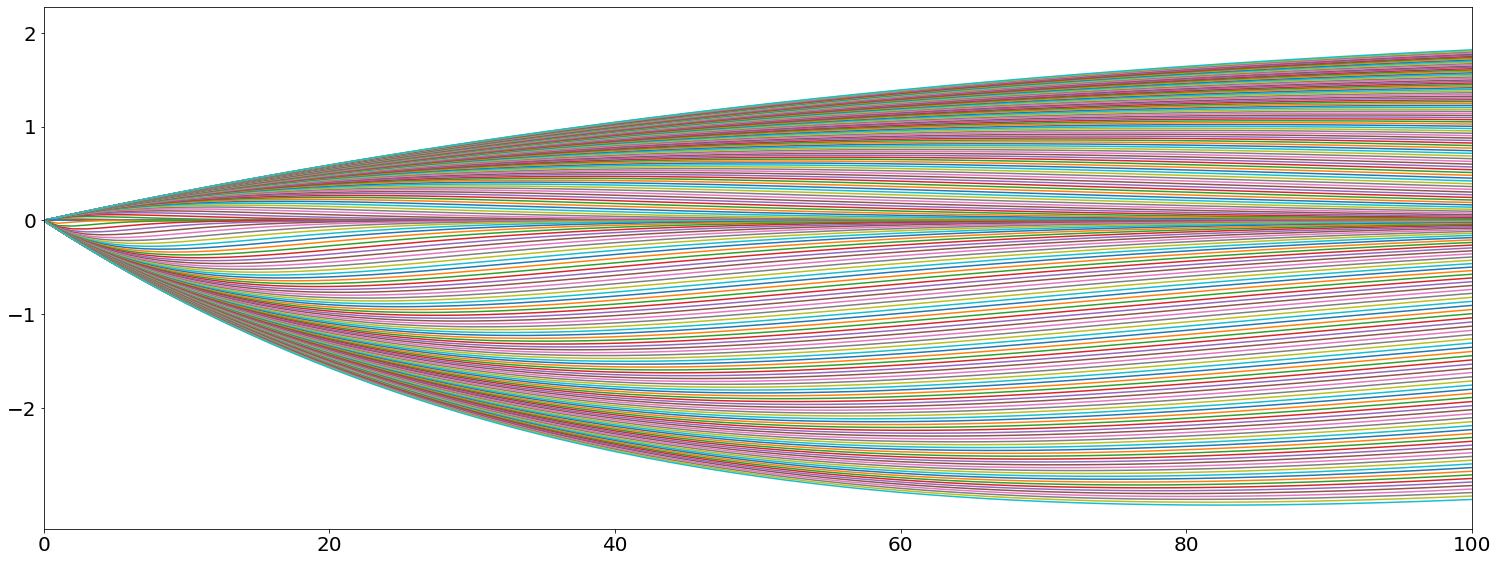

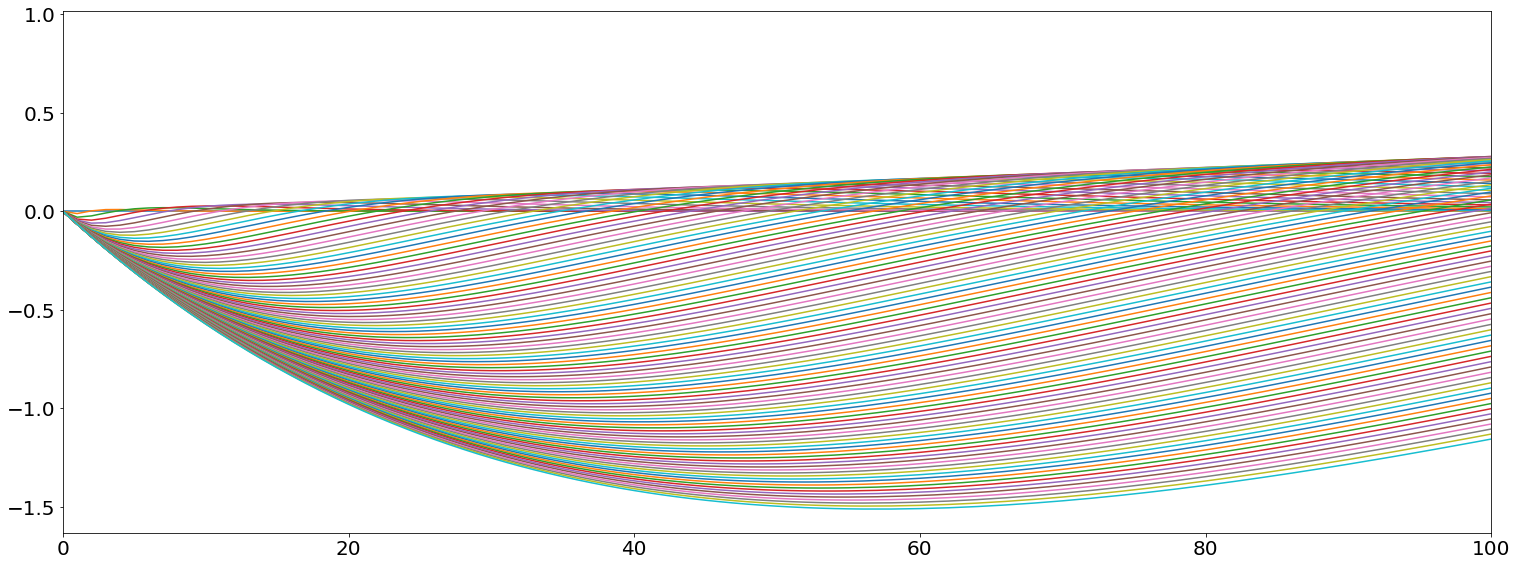

In [3168]:
t = np.linspace(0.0001, 100, 1000)
expfamily = np.zeros((100, 1000))
negfamily = np.zeros((100, 1000))
print(expfamily.shape)
for sig in range(1, 100):
	expfamily[sig,:] = 1/3*t*np.exp(-6*t/sig)
	negfamily[sig,:] = -t*np.exp(-12*t/sig)


#plt.xlim(0, )
plt.yticks((4, 2, 1, 0, -1, -2, -4))
#plt.ylim(0, 1)
plt.plot(expfamily.T)
#plt.figure()
plt.xlim(0, 100)
#plt.yticks((0, 1))
plt.plot(negfamily.T)
plt.figure()
tranfamily = negfamily+expfamily
plt.plot(tranfamily.T)
#plt.yticks((-1, -2, 0, 0.5, 1, np.max(tranfamily, axis=1)[0]))
#plt.ylim(0, 1)
plt.xlim(0, 100)
pass

(100, 1000)


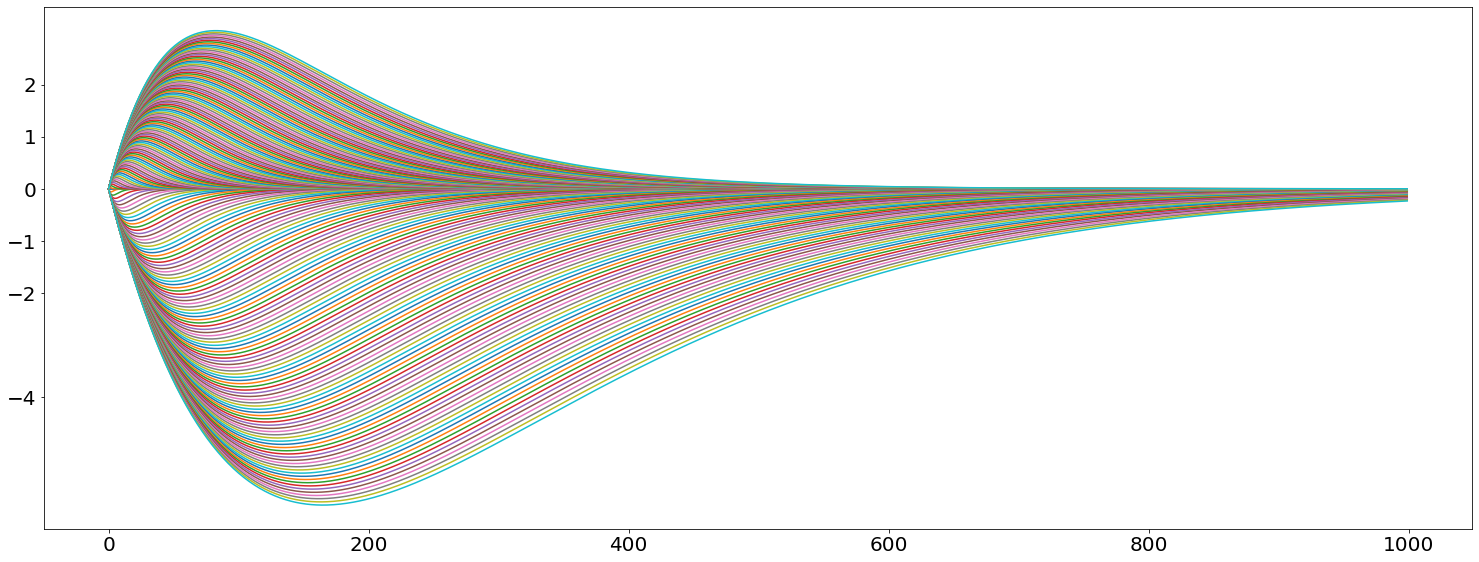

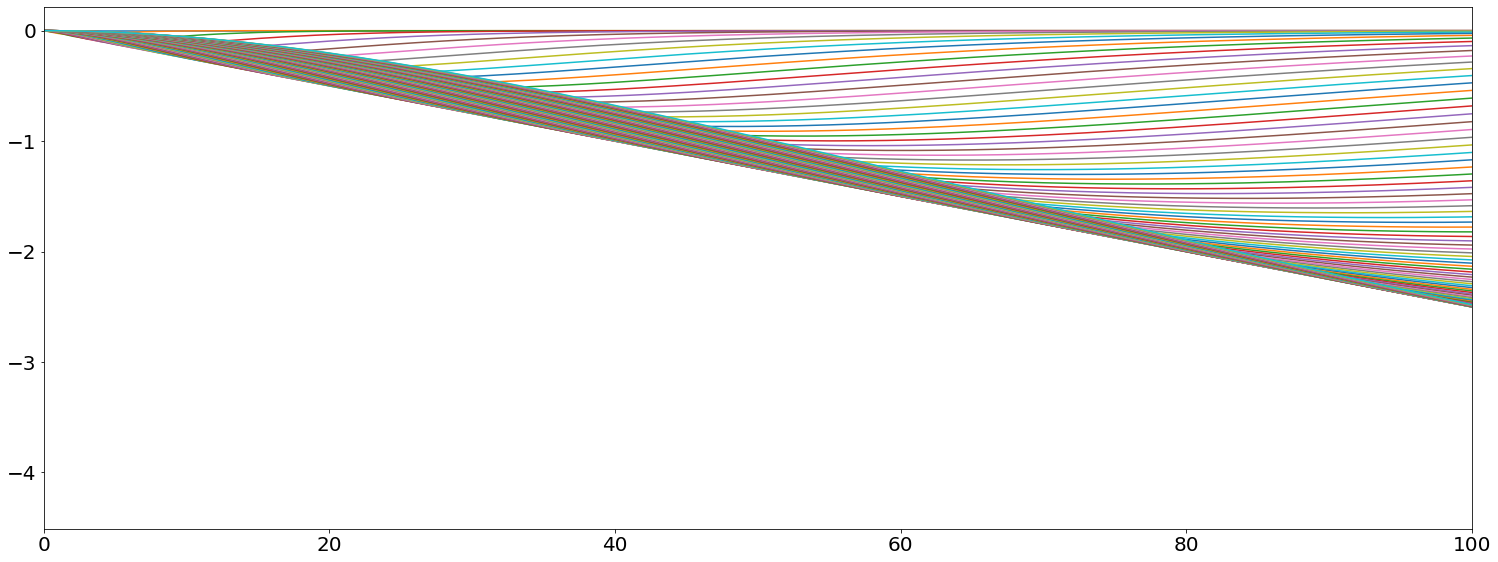

In [3169]:
ly = np.zeros((100, 1000))
negfamily = np.zeros((100, 1000))
print(expfamily.shape)
for sig in range(1, 100):
	expfamily[sig,:] = -t*np.exp(-6*t/sig)
	negfamily[sig,:] = t*np.exp(-12*t/sig)
	#expfamily[sig,:] = 1/2*t*np.exp(-t/12*sig)
	#negfamily[sig,:] = -t*np.exp(-t/6*sig)


#plt.xlim(0, )
plt.yticks((4, 2, 1, 0, -1, -2, -4))
#plt.ylim(0, 1)
plt.plot(expfamily.T)
#plt.figure()
#plt.xlim(0, 200)
#plt.ylim(-1, 1)
#plt.yticks((0, 1))
plt.plot(negfamily.T)
plt.figure()
tranfamily = negfamily+expfamily
plt.plot(tranfamily.T)
#plt.yticks((-1, -2, 0, 0.5, 1, np.max(tranfamily, axis=1)[0]))
#plt.ylim(0, 1)
plt.xlim(0, 100)
pass